In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace, GenerationConfig
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [4]:
# nsr = FlashANSR(
#     expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
#     flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
#     # generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 128, top_p=0.99, temperature=1.5),
#     generation_config=GenerationConfig(method='beam_search', beam_width=1024 * 128),
#     n_restarts=8,
#     parsimony=0.05,
# ).to(device)

# print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

In [5]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.from_config(get_path('configs', 'v7.0', 'nsr.yaml')),
    # generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 128, top_p=0.99, temperature=1.5),
    generation_config=GenerationConfig(method='beam_search', beam_width=128),
    n_restarts=8,
    parsimony=0.05,
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,858,466 parameters


In [6]:
demo_expression = [
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('0.1 * ((1.1 / x)**(12) - (1.2 / x)**6)', (0.1, 1.1, 1.2), (0.8, 2.5)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85)))', (5.3, 1, 0.72, 2.85), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x)', (5.3, 1, 0.72, 2.85, 1.5), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x) + (0.1 * x**2)', (5.3, 1, 0.72, 2.85, 1.5, 0.1), (-10, 10)),
][-1]

In [7]:
expression, constants, xlim = demo_expression

In [8]:
prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [9]:
x = np.random.uniform(*xlim, 256)
y = demo_function(x)
if isinstance(y, float):
    y = np.full_like(x, y)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

# Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
pad_length = nsr.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[-1] - y_tensor.shape[-1]

if pad_length > 0:
    x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
print(data_tensor.shape)

torch.Size([256, 4])


In [9]:
nsr.fit(x_tensor, y_tensor, verbose=True)

Generating beams (max length: 32):   9%|▉         | 3/32 [00:01<00:19,  1.48it/s, completed=0, pruned=18]

In [10]:
nsr.get_expression()

'pow2(x2)'

In [11]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

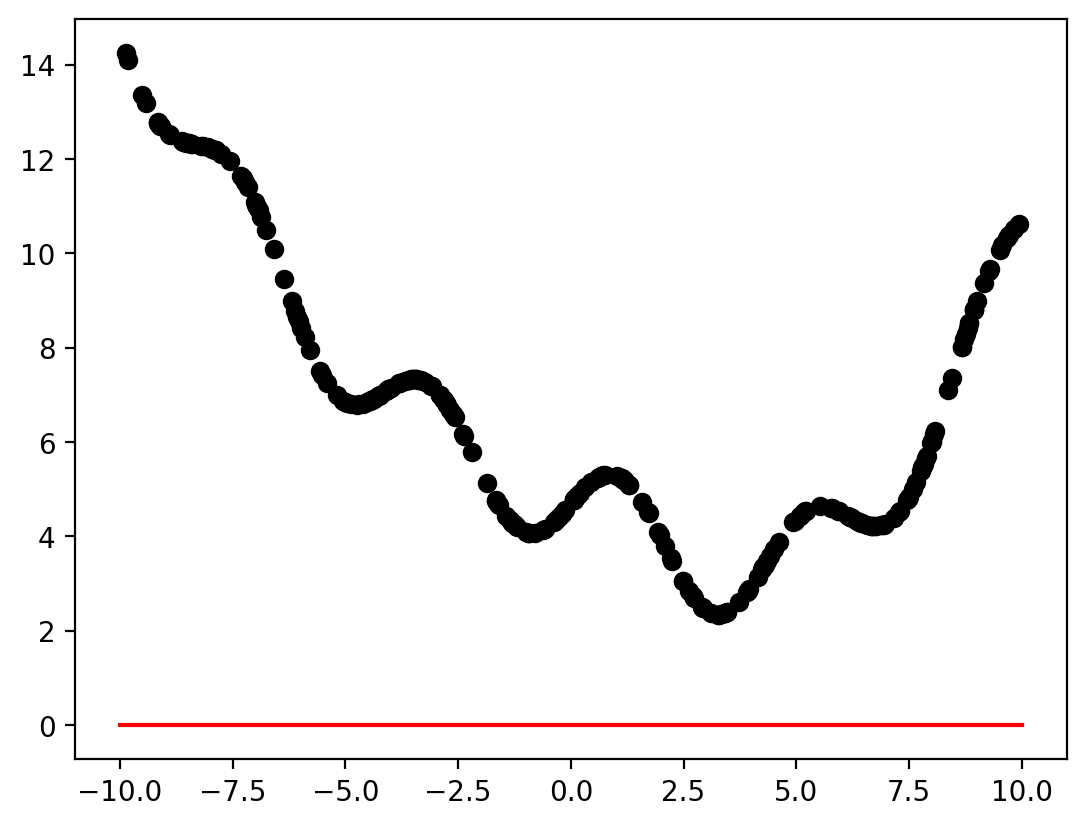

In [12]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/tmp/ipykernel_1613/867298062.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


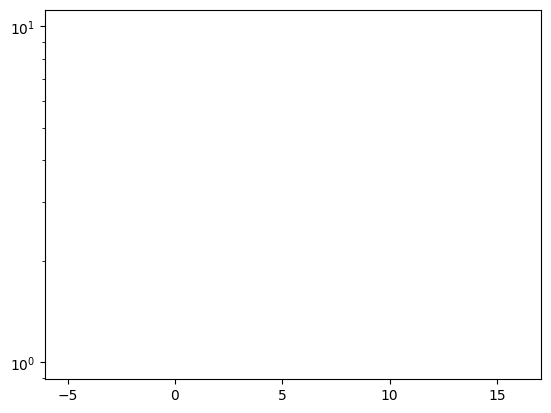

In [14]:
plt.hist(np.log10(nsr.results['fvu'] + np.finfo(np.float64).eps), bins=np.linspace(-5, 16, 64));
plt.yscale('log')

In [ ]:
nsr.specialize(
    x_tensor,
    y_tensor,
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024, top_p=0.99, temperature=1),
    priority_queue_size=32,
    verbose=True,
    parsimony=0.05,
    n_iter=10_000
)

Specializing:   2%|▏         | 236/10000 [40:57<23:03:16,  8.50s/it, NLL=1.02e-01, H=2.06e+00, Max Queue Objective=0.2, Min Queue Objective=-0.0, Min FVU=9.96e-01, Explored=359, Best Expression=<num> * (<num> + pow5(pow2(pow1_3(x1))))]

In [9]:
histories = {k: [log[k] for log in nsr.specialize_history] for k in nsr.specialize_history[0]}

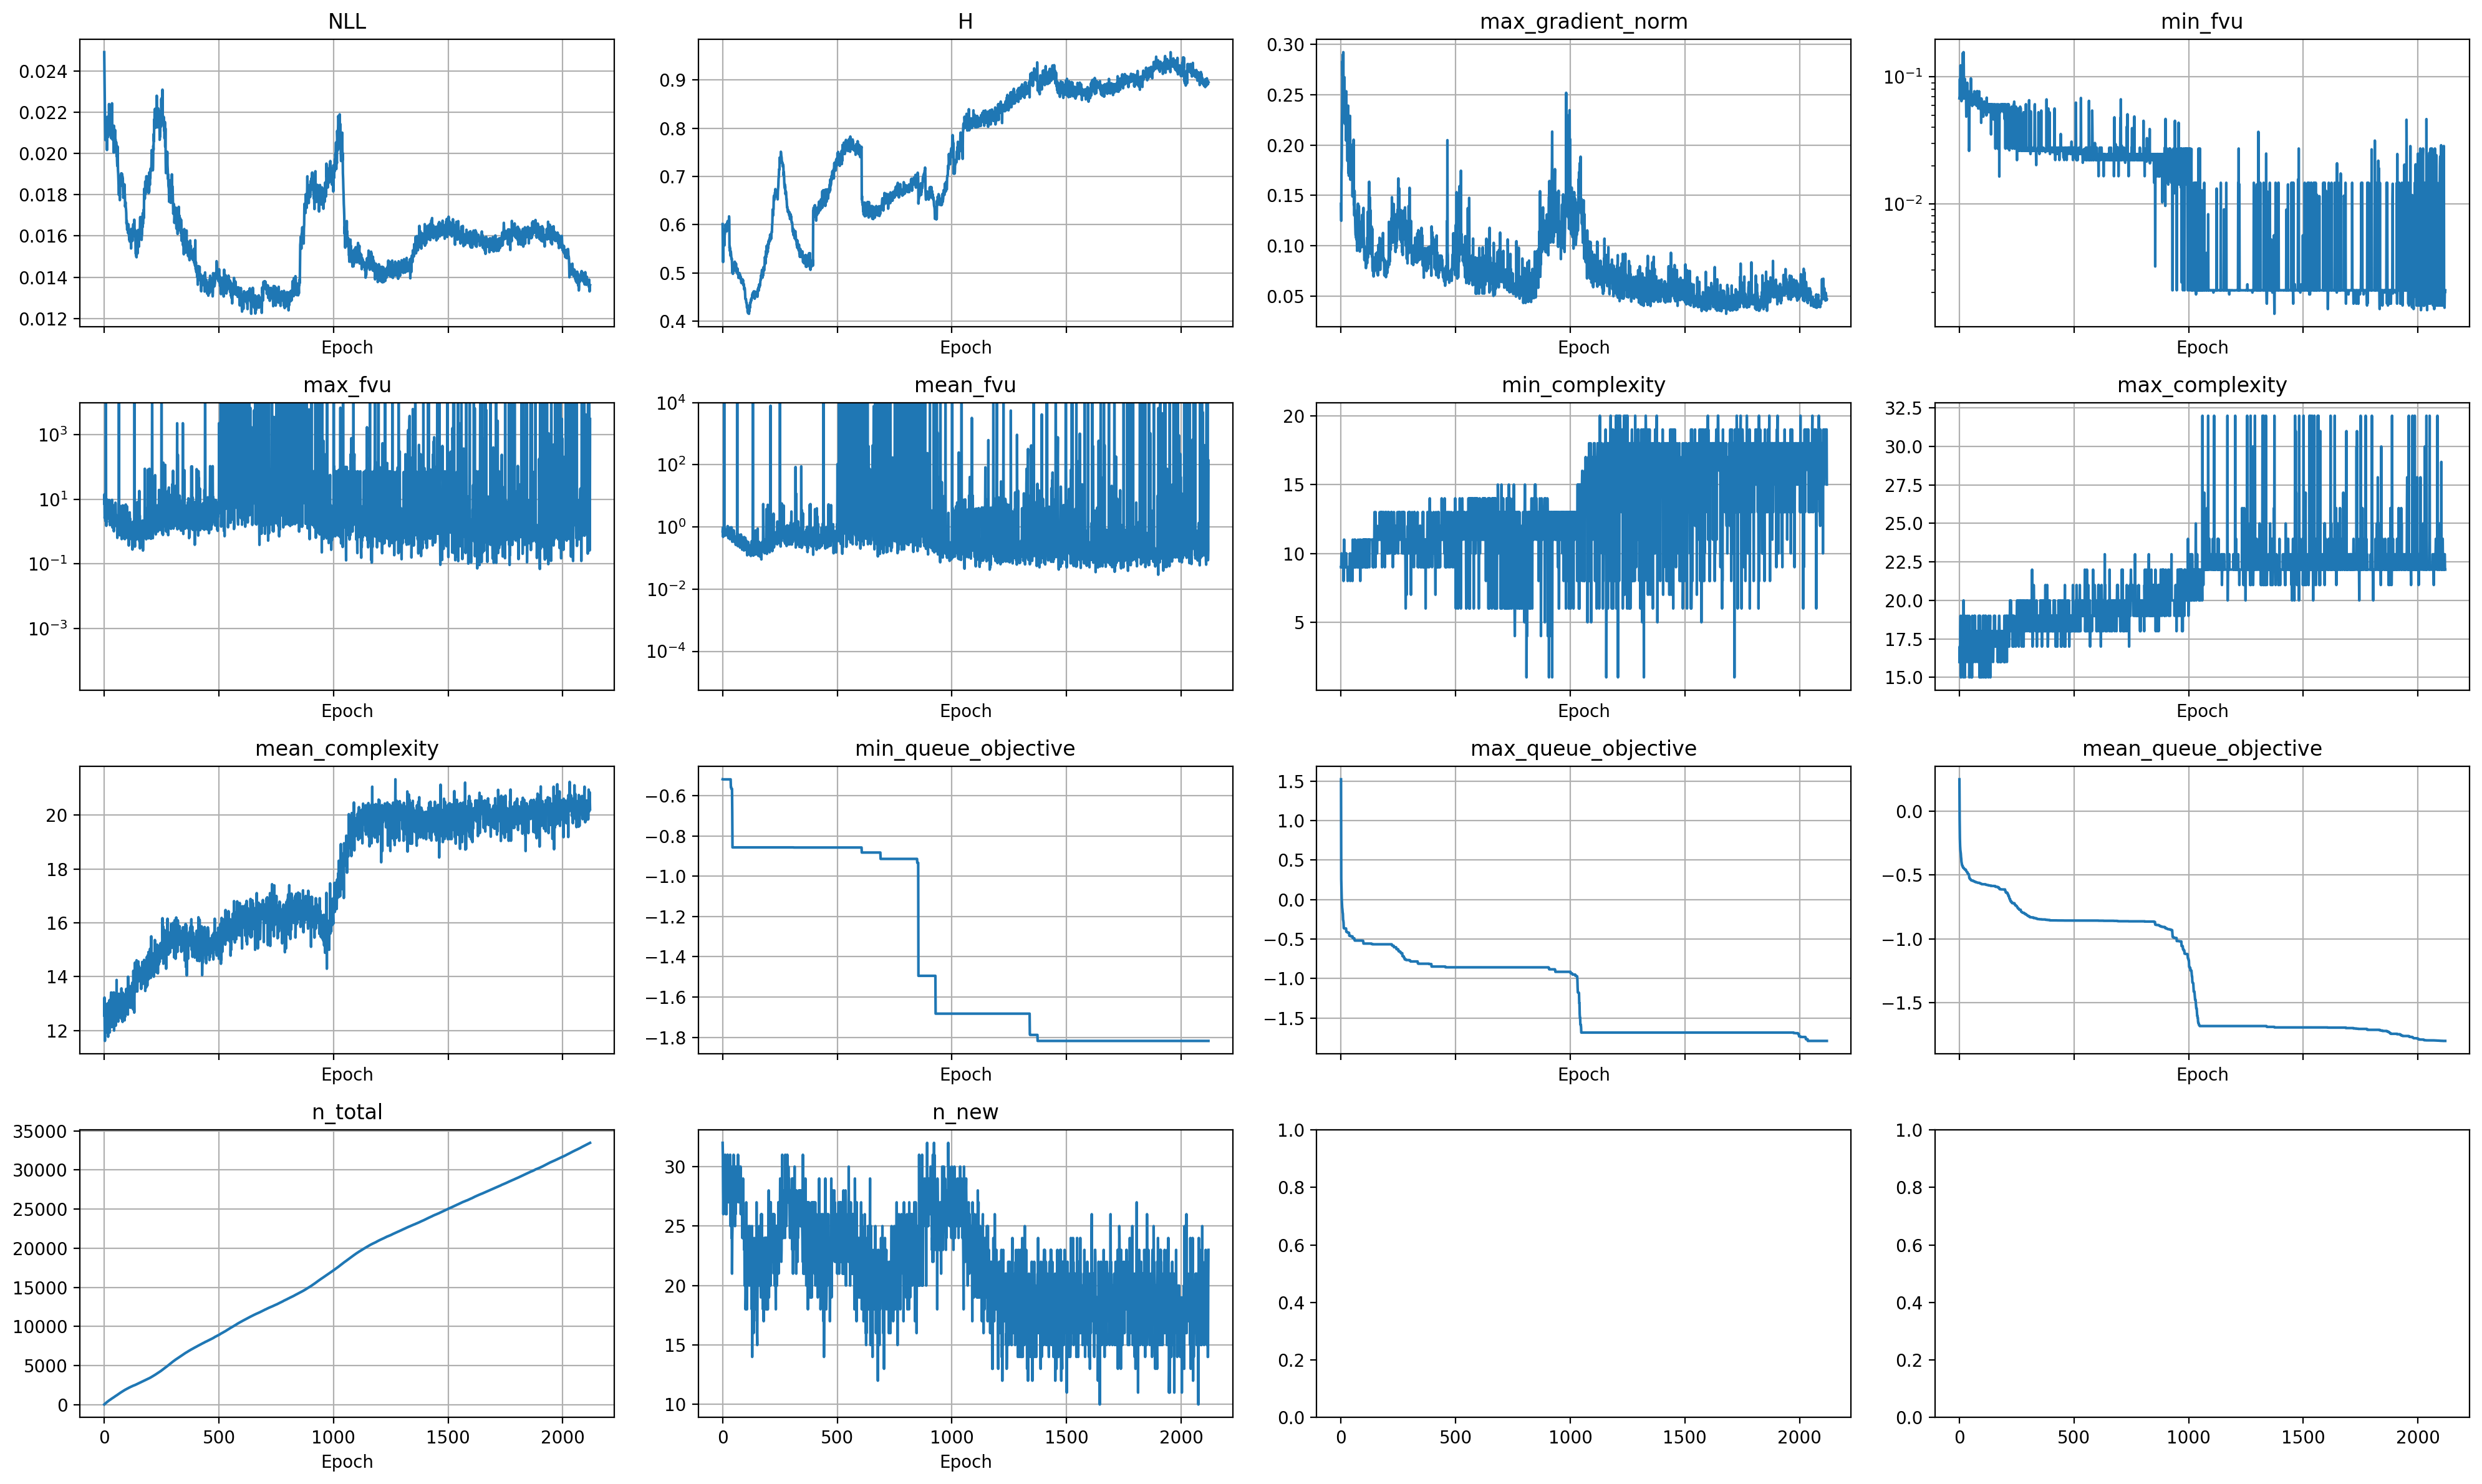

In [11]:
COLS = 4
ROWS = np.ceil(len(histories) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200, sharex=True)

for ax, (k, v) in zip(axes.flat, histories.items()):
    valid_v = [x for x in v if np.isfinite(x)]
    ax.plot(range(len(v)), v)
    ax.set_xlabel('Epoch')
    ax.set_title(k)
    ax.grid()

    if 'fvu' in k:
        ax.set_yscale('log')

        if max(valid_v) > 10000:
            ax.set_ylim(None, 10000)

fig.tight_layout()

In [11]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    # generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 128, top_p=0.99, temperature=1.5),
    generation_config=GenerationConfig(method='beam_search', beam_width=1024 * 128),
    n_restarts=8,
    parsimony=0.05,
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [12]:
nsr.specialize(
    x_tensor,
    y_tensor,
    generation_config=GenerationConfig(method='softmax_sampling', choices=32, top_p=0.99, temperature=1),
    priority_queue_size=32,
    verbose=True,
    parsimony=0.05,
    n_iter=10_000,
    debug_no_optimizer_step=True
)

Specializing: 100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s, NLL=2.63e-02, H=4.94e-01, Max Queue Objective=-1.2, Min Queue Objective=-1.6, Min FVU=6.65e-02, Explored=5354, Best Expression=<num> + (abs(<num> + x1) + ((<num> * sin(<num> * x1)) - atan(<num> * x1)))]


In [13]:
histories = {k: [log[k] for log in nsr.specialize_history] for k in nsr.specialize_history[0]}

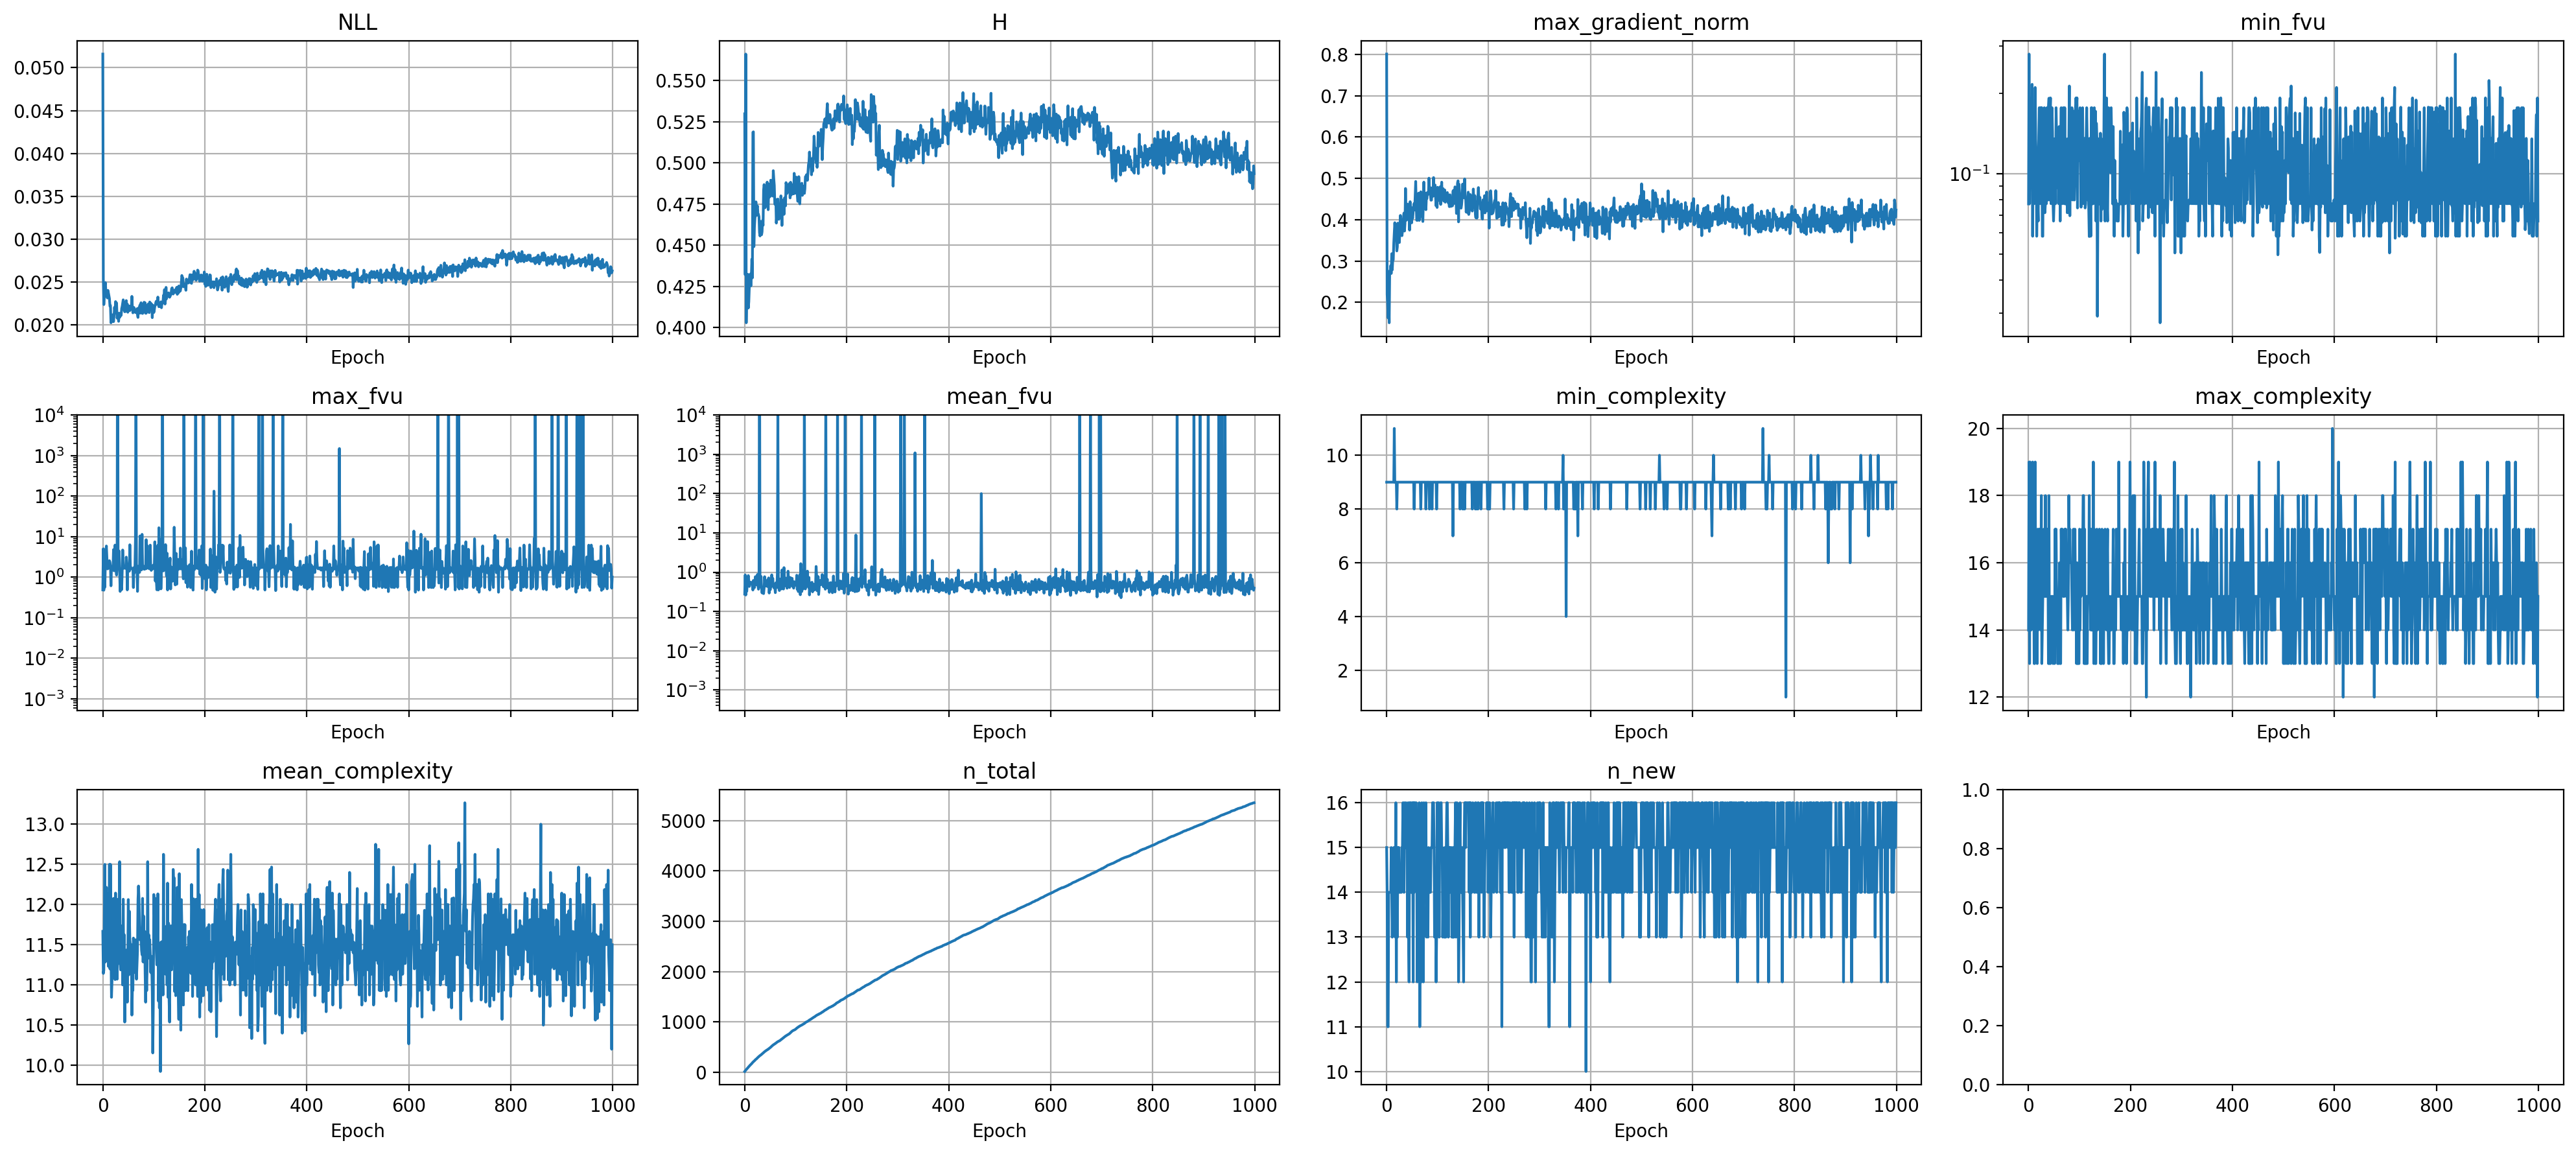

In [14]:
COLS = 4
ROWS = np.ceil(len(histories) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200, sharex=True)

for ax, (k, v) in zip(axes.flat, histories.items()):
    valid_v = [x for x in v if np.isfinite(x)]
    ax.plot(range(len(v)), v)
    ax.set_xlabel('Epoch')
    ax.set_title(k)
    ax.grid()

    if 'fvu' in k:
        ax.set_yscale('log')

    if max(valid_v) > 10000:
        ax.set_ylim(None, 10000)

fig.tight_layout()